# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\wolf0\AppData\Local\Temp\ipykernel_2512\3674931809.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").mean(numeric_only=True)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean(numeric_only=True))
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

C:\Users\wolf0\AppData\Local\Temp\ipykernel_2512\1203636352.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)


# Find correlations

In [9]:
correlations = combined.corr(numeric_only=True)
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

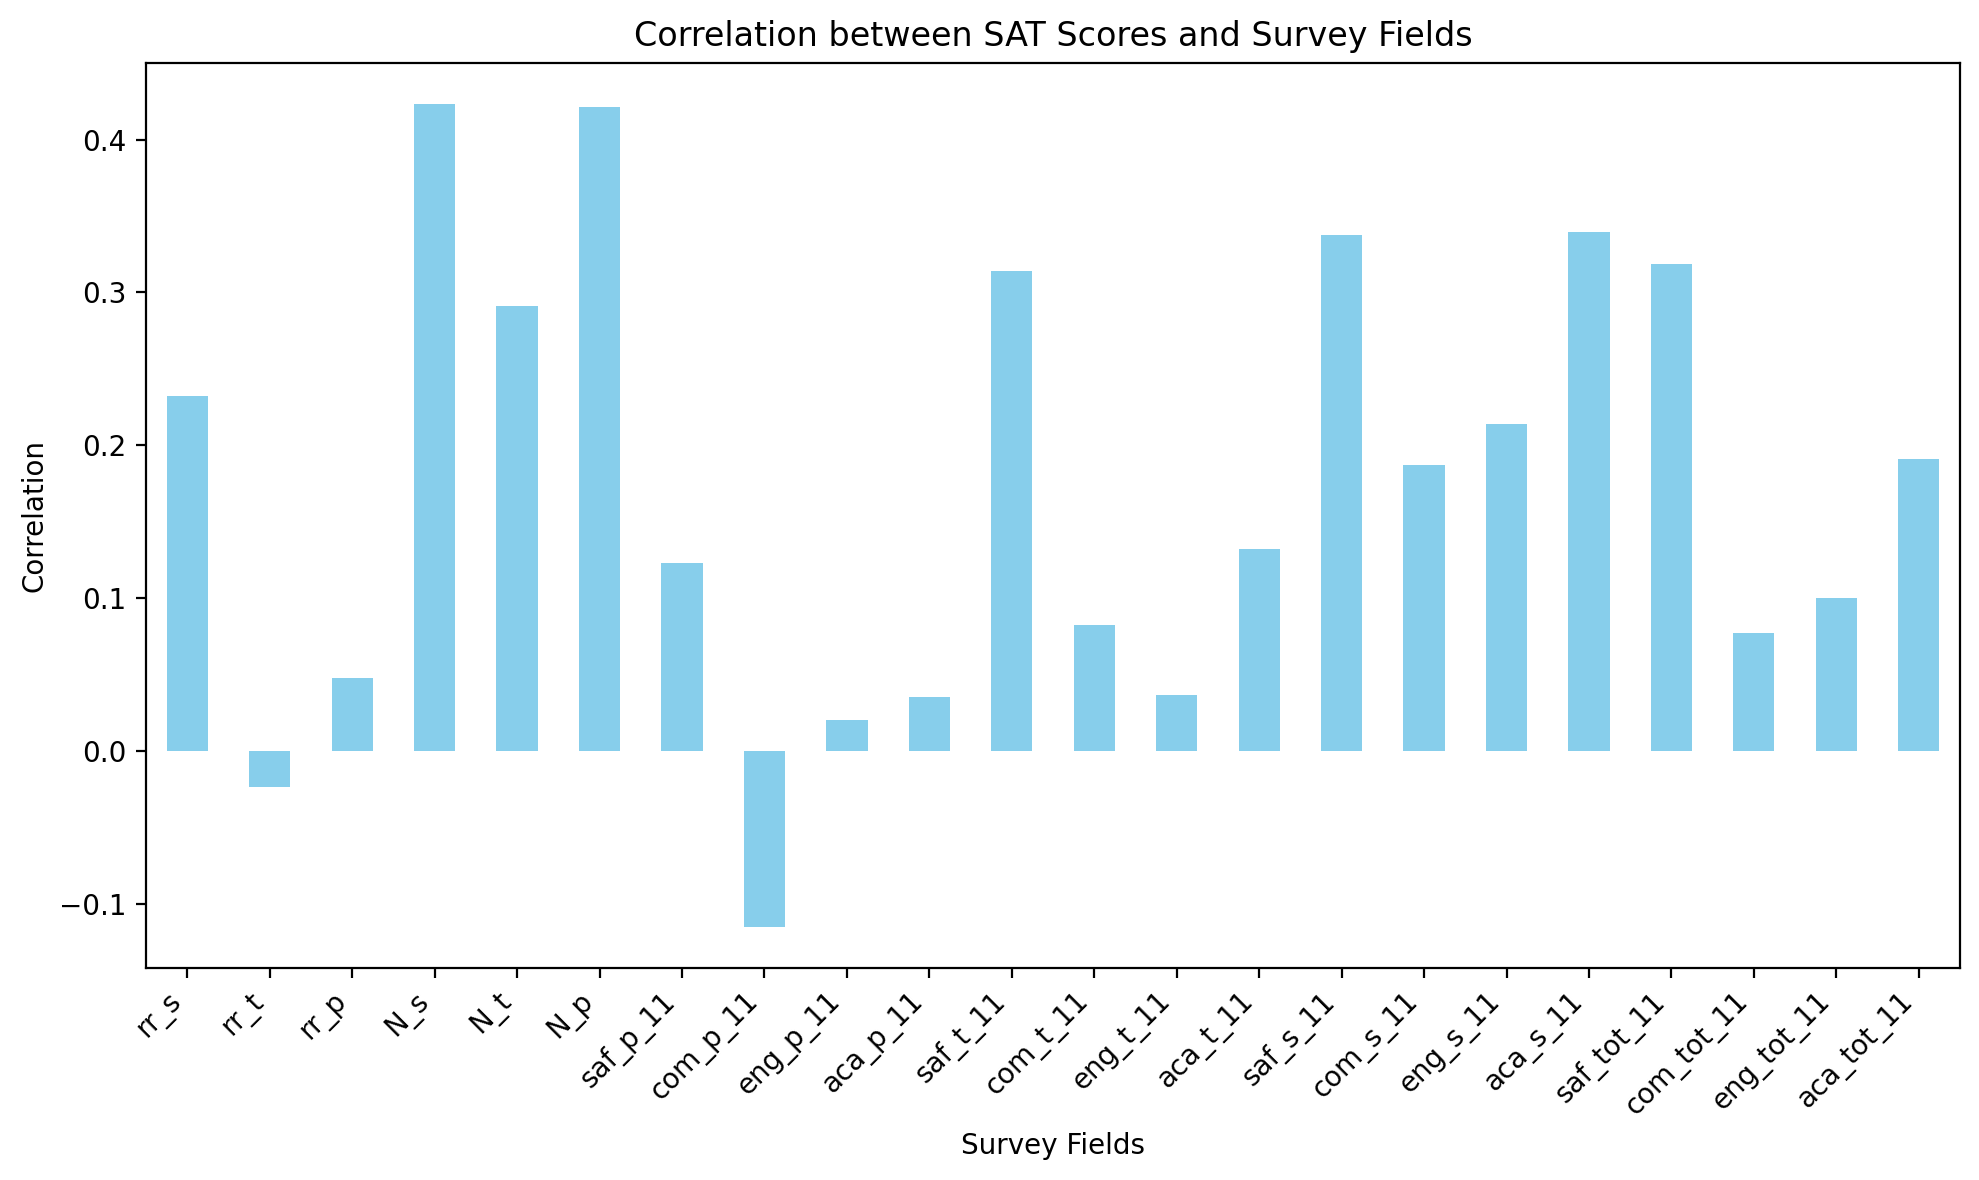

In [11]:
# %matplotlib inline
# combined.corr(numeric_only=True)['sat_score'][survey_fields].plot.bar()
sat_corr = combined.corr(numeric_only=True)['sat_score'][survey_fields]
# # Create bar plot
plt.figure(figsize=(10, 6), dpi=200)
sat_corr.plot(kind='bar', color='skyblue')
plt.title('Correlation between SAT Scores and Survey Fields')
plt.xlabel('Survey Fields')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  
plt.show()

There are high correlations between N_s, N_t, N_p, and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense — it's difficult to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

### Exploring Safety and SAT Scores

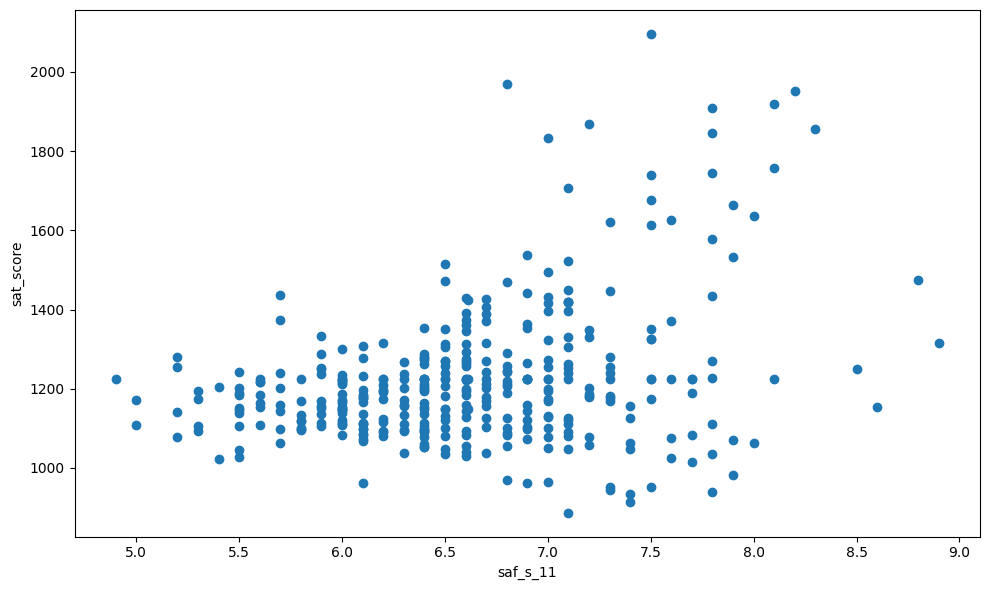

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(x=combined['saf_s_11'], y=combined['sat_score'])
plt.xlabel('saf_s_11')
plt.ylabel('sat_score')
plt.tight_layout() 
plt.show()

There appears to be a correlation between SAT scores and safety, although it isn't very strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

In [13]:
#Display all columns of the combined dataset
col_names = list(combined.columns.values)
print(col_names)

['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers', 'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score', 'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5', 'Demographic', 'School Name', 'Cohort', 'Total Cohort', 'Total Grads - n', 'Total Grads - % of cohort', 'Total Regents - n', 'Total Regents - % of cohort', 'Total Regents - % of grads', 'Advanced Regents - n', 'Advanced Regents - % of cohort', 'Advanced Regents - % of grads', 'Regents w/o Advanced - n', 'Regents w/o Advanced - % of cohort', 'Regents w/o Advanced - % of grads', 'Local - n', 'Local - % of cohort', 'Local - % of grads', 'Still Enrolled - n', 'Still Enrolled - % of cohort', 'Dropped Out - n', 'Dropped Out - % of cohort', 'CSD', 'NUMBER OF STUDENTS / SEATS FILLED', 'NUMBER OF SECTIONS', 'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS', 'SCHOOLWIDE PUPIL-TEACHER RATIO', 'Name', 'schoolyear', 'fl_percent', 'frl_percen

In [14]:
combined['boro']

0      Manhattan
1      Manhattan
2      Manhattan
3      Manhattan
4      Manhattan
         ...    
358     Brooklyn
359     Brooklyn
360     Brooklyn
361     Brooklyn
362     Brooklyn
Name: boro, Length: 363, dtype: object

###  The average safety score for each borough.

In [15]:
boros = combined.groupby('boro').mean(numeric_only=True)["saf_s_11"]
boros

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

Bronx and Queens  tend to have higher safety scores, and Brooklyn has the lowest.


### Exploring Race and SAT Scores

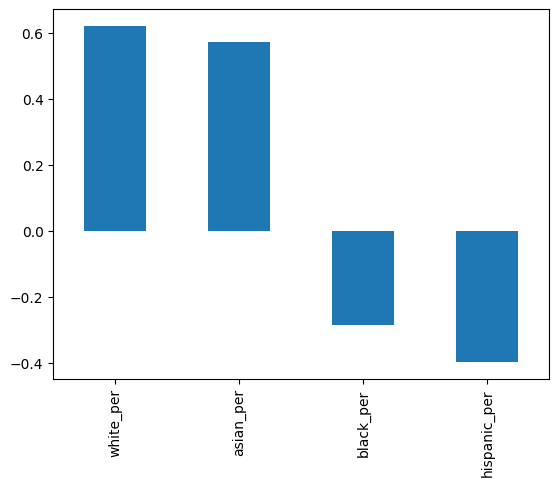

In [16]:
races = ['white_per','asian_per','black_per','hispanic_per']
combined.corr(numeric_only=True)['sat_score'][races].plot.bar()
plt.show()

It looks like a higher percentage of white or Asian students at a school correlates positively with SAT scores, whereas a higher percentage of black or Hispanic students correlates negatively with SAT score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or Hispanic students.



### Schools with low SAT scores and high values for hispanic_per

<Figure size 1000x800 with 0 Axes>

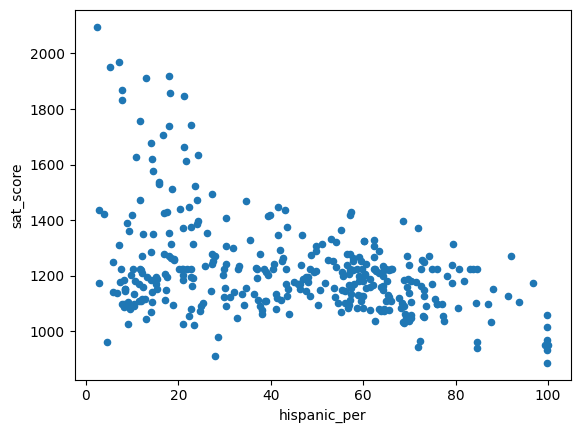

In [17]:
plt.figure(figsize=(10, 8))
combined.plot.scatter('hispanic_per','sat_score')
plt.show()

The data reveals that roughly 25% of Hispanic students achieved SAT scores of 1800 and higher, while the predominant range for SAT scores among Hispanic students centers around 1200.

In [18]:
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above appear to primarily serve recent immigrants to the U.S. These schools have many students who are learning English, which would explain the lower SAT scores.

In [19]:
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Many of the schools above appear to be specialized science and technology schools that receive extra funding and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT — they are students from all over New York City who did well on a standardized test.

### Exploring Gender and SAT Scores

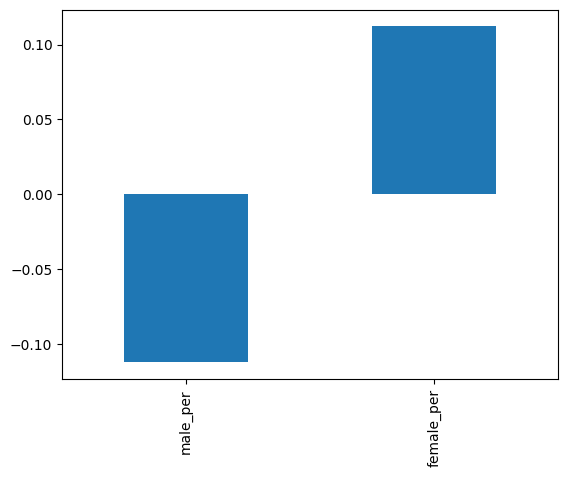

In [20]:
gender_fields = ['male_per','female_per']
combined.corr(numeric_only=True)['sat_score'][gender_fields].plot.bar()
plt.show()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT scores, whereas a high percentage of males at a school negatively correlates with SAT scores. Neither correlation is extremely strong.



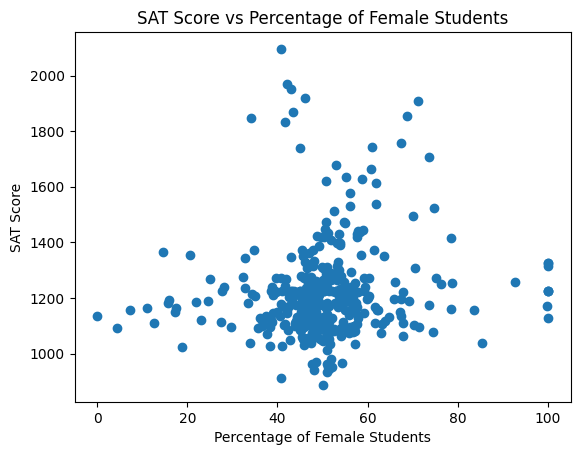

In [21]:
plt.scatter(combined['female_per'], combined['sat_score'])
plt.xlabel('Percentage of Female Students')
plt.ylabel('SAT Score')
plt.title('SAT Score vs Percentage of Female Students')
plt.show()

Based on the scatter plot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80) and high SAT scores.

In [22]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appear to be very selective liberal arts schools that have high academic standards.

###  Exploring AP Scores vs. SAT Scores

In [23]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']


C:\Users\wolf0\AppData\Local\Temp\ipykernel_2512\2706117576.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']


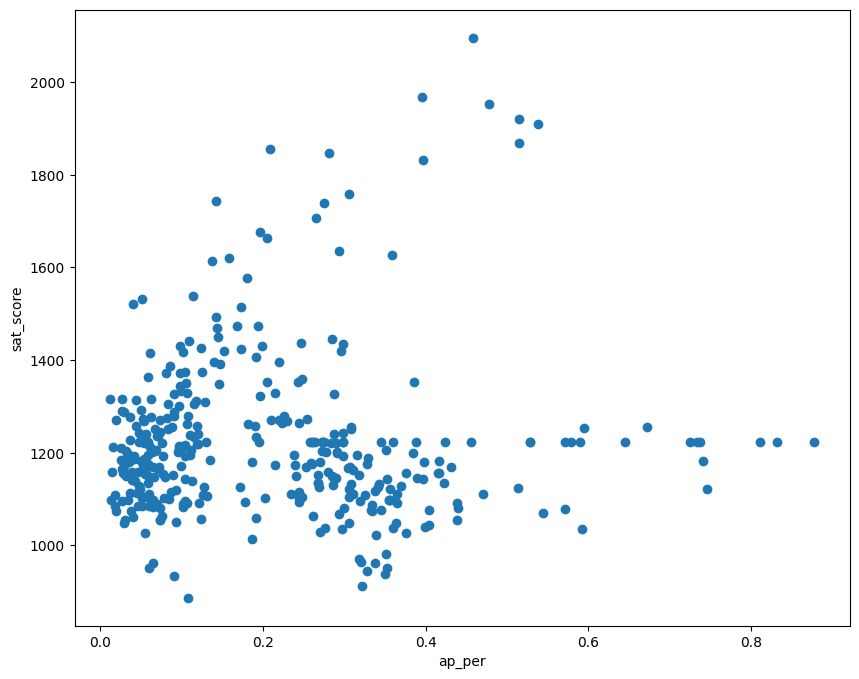

In [24]:
plt.figure(figsize=(10, 8))
plt.scatter(combined['ap_per'], combined['sat_score'])
plt.xlabel('ap_per')
plt.ylabel('sat_score')
plt.show()

It looks like there is a relationship between the percentage of students in a school who take the AP exam and their average SAT scores. It's not a very strong correlation, however.

### Correlation between the class sizes and SAT scores 

In [25]:
combined['AVERAGE CLASS SIZE']

0      22.564286
1      22.231250
2      21.200000
3      23.571429
4      25.510526
         ...    
358    22.958824
359    22.760000
360    23.900000
361    17.793750
362    25.060000
Name: AVERAGE CLASS SIZE, Length: 363, dtype: float64

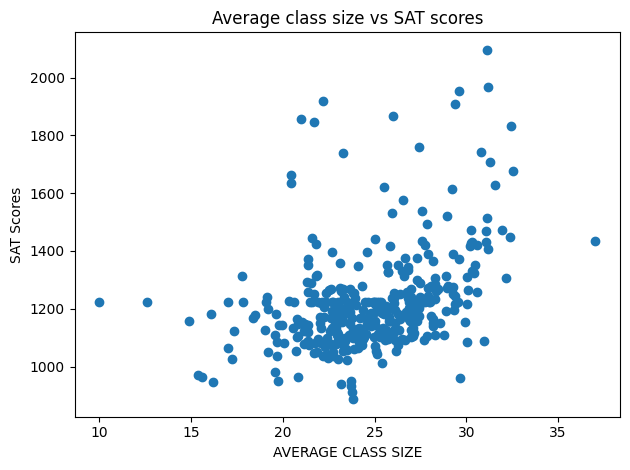

In [26]:
# plt.figure(figsize=(10, 8))
plt.scatter(combined['AVERAGE CLASS SIZE'], combined['sat_score'])
plt.xlabel('AVERAGE CLASS SIZE')
plt.ylabel('SAT Scores')
plt.title('Average class size vs SAT scores')
plt.tight_layout()
plt.show()

The chart suggests a positive correlation between class size and SAT scores, indicating that larger classes tend to correspond with higher SAT scores.

### Neighborhoods with the best schools: based on SAT scores

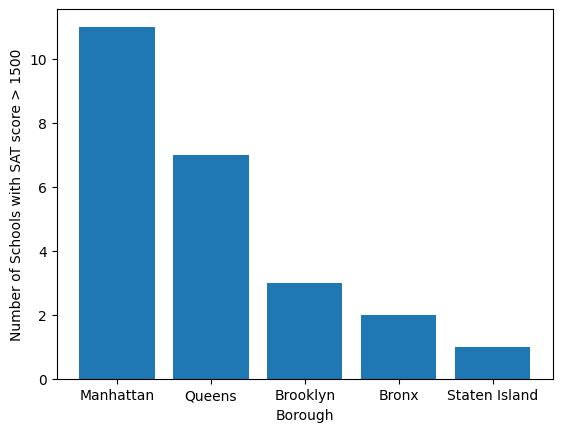

In [27]:
#Filter df: selecting sat_scores > 1500
high_sat_scores = combined[combined['sat_score'] > 1500]
#Count the occurences of each borough
boro_counts = high_sat_scores['boro'].value_counts()
# print(boro_counts)

#Plotting
plt.bar(boro_counts.index, boro_counts.values)
plt.xlabel('Borough')
plt.ylabel('Number of Schools with SAT score > 1500')
plt.show()


In [28]:
#Display all columns names
# for col_name in combined.columns:
#     print(col_name)
# combined['Total Grads - % of cohort']

### Correlation between SAT Scores and Graduation/Dropout Rates

In [29]:
#Convert a column 'Total Grads - % of cohort'. 
#pd.to_numeric allows to handle  non-numeric values
combined['Total Grads - % of cohort'] = combined['Total Grads - % of cohort'].str.replace('%','')
combined['Total Grads - % of cohort'] = pd.to_numeric(combined['Total Grads - % of cohort'], errors='coerce')
# combined['Total Grads - % of cohort'] = combined['Total Grads - % of cohort'].astype(float)
# combined['Total Grads - % of cohort']

In [30]:
#Convert dropouts % to float. 
combined['Dropped Out - % of cohort'] = combined['Dropped Out - % of cohort'].str.replace('%', '')
combined['Dropped Out - % of cohort'] = pd.to_numeric(combined['Dropped Out - % of cohort'], errors='coerce')
# combined['Dropped Out - % of cohort'] = combined['Dropped Out - % of cohort'].astype(float)
# combined['Dropped Out - % of cohort'



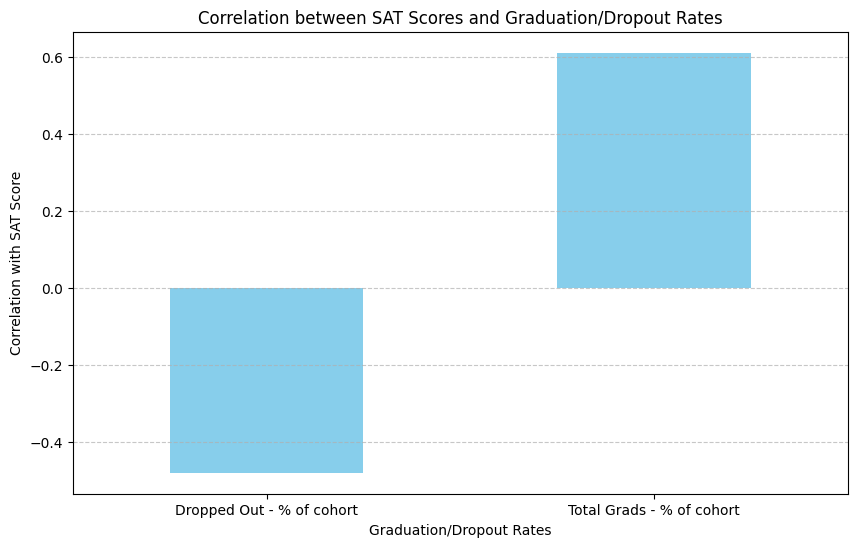

In [31]:
drop_grad = ['Dropped Out - % of cohort', 'Total Grads - % of cohort']
drop_grad_corr = combined.corr(numeric_only=True)['sat_score'][drop_grad]

#Plot correlation between SAT score and dropouts/grad rates
drop_grad_corr.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Correlation between SAT Scores and Graduation/Dropout Rates')
plt.xlabel('Graduation/Dropout Rates')
plt.ylabel('Correlation with SAT Score')
plt.xticks(rotation=360)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

There is a strong correlation between SAT score and percentage of graduates and dropouts. 

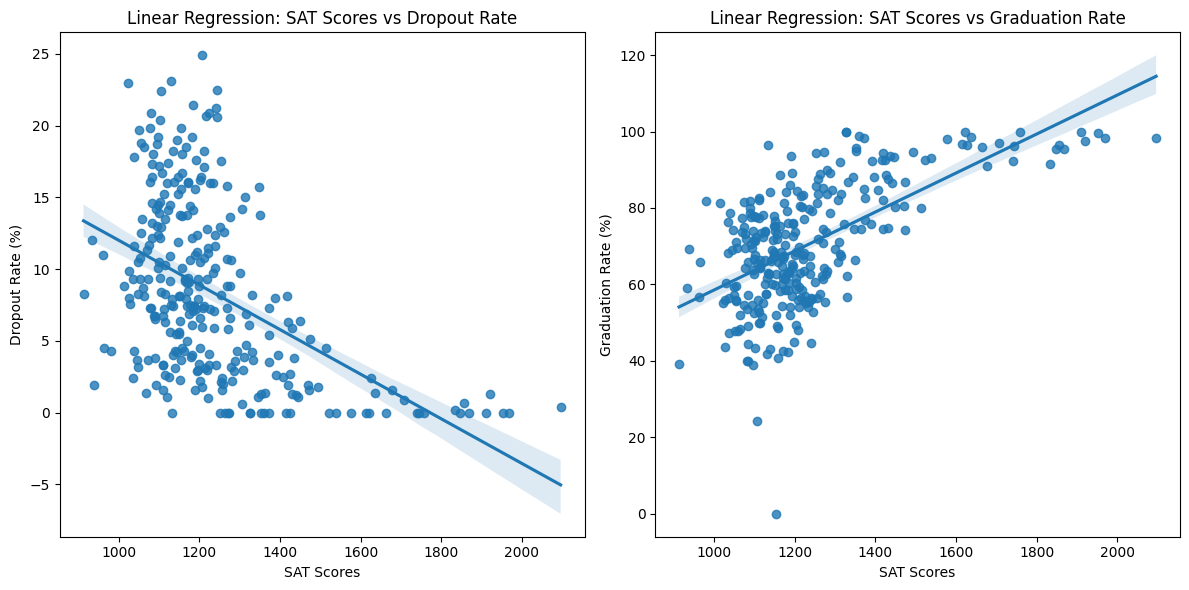

In [32]:
#Create regresison graphs for dropout and graduation rates.
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize for better view

sns.regplot(x='sat_score', y='Dropped Out - % of cohort', data=combined, ax=axes[0])
axes[0].set_title('Linear Regression: SAT Scores vs Dropout Rate')
axes[0].set_xlabel('SAT Scores')
axes[0].set_ylabel('Dropout Rate (%)')

sns.regplot(x='sat_score', y='Total Grads - % of cohort', data=combined, ax=axes[1])
axes[1].set_title('Linear Regression: SAT Scores vs Graduation Rate')
axes[1].set_xlabel('SAT Scores')
axes[1].set_ylabel('Graduation Rate (%)')

plt.tight_layout()

plt.show()

Furthermore, there appears to be a negative correlation between dropout rates and SAT scores, indicating that lower SAT scores are associated with higher dropout rates, while higher SAT scores are linked to increased graduation rates.